In [1]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

d:\PythonProjects\ViTPose\ViTPoseEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cuda


In [3]:
image_path = "../Data/Image/running_man.jpg"
image = Image.open(image_path)

In [4]:
# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

In [6]:
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

In [7]:
# Human label refers 0 index in COCO dataset
person_boxes_xyxy = result["boxes"][result["labels"] == 0]
person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes = person_boxes_xyxy.copy()
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]
person_boxes

array([[1136.4597 ,  271.12903,  650.05786,  849.90686]], dtype=float32)

In [8]:
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [9]:
inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

In [10]:
# for vitpose-plus-base checkpoint we should additionaly provide dataset_index
# to sepcify which MOE experts to use for inference
if model.config.backbone_config.num_experts > 1:
    dataset_index = torch.tensor([0] * len(inputs["pixel_values"]))
    dataset_index = dataset_index.to(inputs["pixel_values"].device)
    inputs["dataset_index"] = dataset_index

In [11]:
with torch.no_grad():
    outputs = model(**inputs)

In [12]:
pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image

print(image_pose_result)

[{'keypoints': tensor([[1205.2905,  374.3501],
        [1220.0762,  353.8246],
        [1199.2196,  357.6810],
        [1278.0713,  351.9337],
        [1204.2214,  363.0034],
        [1362.0039,  403.2510],
        [1238.4891,  464.2938],
        [1497.8092,  403.9912],
        [1249.2526,  593.6542],
        [1549.8623,  525.1218],
        [1192.6813,  547.3149],
        [1440.0520,  645.6308],
        [1385.7563,  669.5573],
        [1330.9778,  807.2277],
        [1506.4209,  858.4882],
        [1342.9027, 1033.9890],
        [1705.5466,  930.8652]]), 'scores': tensor([0.9840, 0.9285, 0.9500, 0.9625, 0.5926, 0.8940, 0.9464, 0.9716, 1.0075,
        0.9890, 0.9863, 0.8700, 0.8067, 0.9592, 0.9757, 0.8954, 0.9095]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([1461.4886,  696.0825, 1464.5515,  700.4996])}]


In [13]:
# print results in more human-readable format
for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        print(type(keypoint))
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")

Person #0
<class 'torch.Tensor'>
 - Nose: x=1205.29, y=374.35, score=0.98
<class 'torch.Tensor'>
 - L_Eye: x=1220.08, y=353.82, score=0.93
<class 'torch.Tensor'>
 - R_Eye: x=1199.22, y=357.68, score=0.95
<class 'torch.Tensor'>
 - L_Ear: x=1278.07, y=351.93, score=0.96
<class 'torch.Tensor'>
 - R_Ear: x=1204.22, y=363.00, score=0.59
<class 'torch.Tensor'>
 - L_Shoulder: x=1362.00, y=403.25, score=0.89
<class 'torch.Tensor'>
 - R_Shoulder: x=1238.49, y=464.29, score=0.95
<class 'torch.Tensor'>
 - L_Elbow: x=1497.81, y=403.99, score=0.97
<class 'torch.Tensor'>
 - R_Elbow: x=1249.25, y=593.65, score=1.01
<class 'torch.Tensor'>
 - L_Wrist: x=1549.86, y=525.12, score=0.99
<class 'torch.Tensor'>
 - R_Wrist: x=1192.68, y=547.31, score=0.99
<class 'torch.Tensor'>
 - L_Hip: x=1440.05, y=645.63, score=0.87
<class 'torch.Tensor'>
 - R_Hip: x=1385.76, y=669.56, score=0.81
<class 'torch.Tensor'>
 - L_Knee: x=1330.98, y=807.23, score=0.96
<class 'torch.Tensor'>
 - R_Knee: x=1506.42, y=858.49, score=0

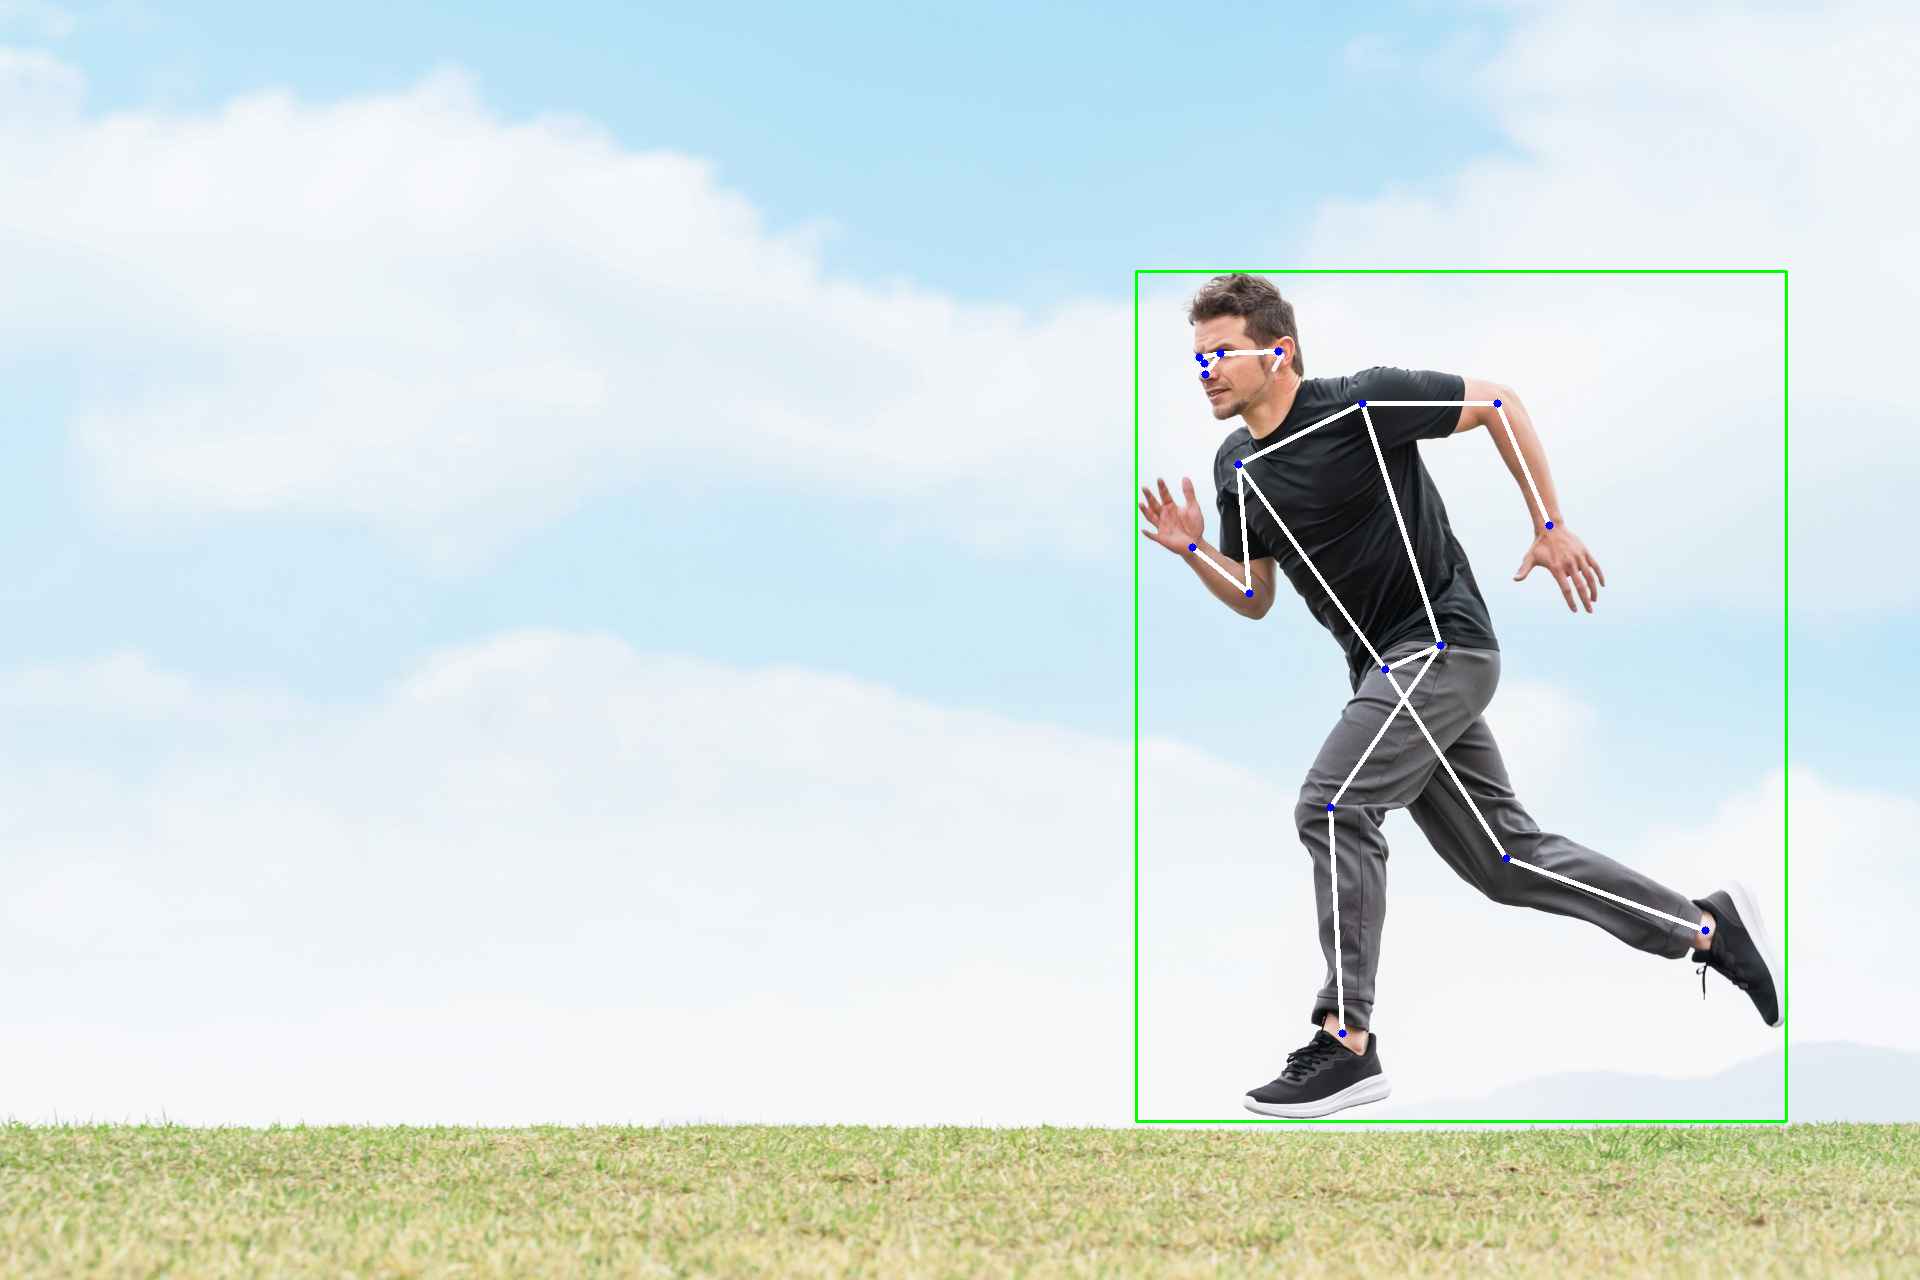

In [19]:
import supervision as sv

# preprocess to torch tensor of shape (n_objects, n_keypoints, 2)
xy = [pose_result['keypoints'] for pose_result in image_pose_result]
xy = torch.stack(xy).cpu().numpy()

scores = [pose_result['scores'] for pose_result in image_pose_result]
scores = torch.stack(scores).cpu().numpy()

keypoints = sv.KeyPoints(xy=xy, confidence=scores)
detections = sv.Detections(xyxy=person_boxes_xyxy)

edge_annotator = sv.EdgeAnnotator(color=sv.Color.WHITE, thickness=3)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.BLUE, radius=4)
bounding_box_annotator = sv.BoxAnnotator(
    color=sv.Color.GREEN, color_lookup=sv.ColorLookup.INDEX, thickness=2
)

annotated_frame = image.copy()

# annotate boundg boxes
annotated_frame = bounding_box_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

# annotate edges and verticies
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=keypoints
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=keypoints
)

annotated_frame

In [15]:
print(type(annotated_frame))

<class 'PIL.Image.Image'>
